In [1]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [2]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib
import lightgbm as lgb


Import necessary libraries


In [3]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [4]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [5]:
version='forPdata423_halfgrid'


In [6]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [7]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,...,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [8]:
uniquePoints=data.loc[data.loc[:,['x','y']].duplicated()==False,['x','y']]
print('we have a target grid of',uniquePoints.shape[0],'unique points')

# sets divided in forPdata423_halfgrid_KNeighbors_wifis_position.ipynb
set1=[85,79,77,68,32,30,28,70,83,80,82,72,8,6,4,26,23,25,21,19,51,33,0,2,62,60,58,56,74,10,53,49,47,65,13,34,46,36,38,15,45,17,41,18]
set2=[84,78,86,67,69,31,29,27,71,81,73,76,7,5,3,24,9,22,20,50,64,1,63,61,59,57,55,52,54,11,48,12,66,75,14,35,37,39,16,40,42,44,43]

uniquePoints['pointNum']=np.arange(len(uniquePoints))
uniquePoints['setNum']=1
uniquePoints.setNum.iloc[set2]=2

data=data.merge(uniquePoints,left_on=['x','y'],right_on=['x','y'])

we have a target grid of 87 unique points


In [9]:
# print('split path-timestamp in 2 columns')
# data[['path','timestamp']]=data['path-timestamp'].str.split('-',expand=True)
# print('remove path-timestamp column')
# data.drop('path-timestamp', axis=1,inplace=True)

In [10]:
dataA=data.copy()

In [11]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp', 'pointNum', 'setNum']]
len(TRAIN_FEATS)

312

In [12]:
unpaths=data.path.unique()

In [13]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


### CV TRAIN

In [14]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 11,
    "num_leaves": 256,  
    "max_bin": 256,
    "num_iterations": 15000
}
# hyper_params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': ['l1','l2'],
#     'learning_rate': 0.005,
#     'feature_fraction': 0.2,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 14,
#     "num_leaves": 256,  
#     "max_bin": 256,
#     "num_iterations": 15000
# }


In [ ]:
# CROSS VALIDATION

name='lgbm'+version


split_score=[]
for split in [1,2]:
    data=dataA.loc[dataA.setNum==split,:]
    data.shape
    unpaths=data.path.unique()
    print('we have ',len(unpaths),' unique paths')
    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=100,
                early_stopping_rounds=200)
            
            # joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            joblib.dump(model, weights_path+name+'split'+str(split)+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    

    print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    split_score.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
print('average splits score', np.mean(split_score))       

we have  423  unique paths
fold: 0
Training until validation scores don't improve for 200 rounds.
[100]	training's l2: 39.6132	training's l1: 4.76095	valid_1's l2: 43.1557	valid_1's l1: 4.9643
[200]	training's l2: 16.6362	training's l1: 3.12606	valid_1's l2: 19.3251	valid_1's l1: 3.36672
[300]	training's l2: 7.69353	training's l1: 2.14164	valid_1's l2: 10.1905	valid_1's l1: 2.44735
[400]	training's l2: 4.10038	training's l1: 1.55087	valid_1's l2: 6.58797	valid_1's l1: 1.93656
[500]	training's l2: 2.56903	training's l1: 1.19898	valid_1's l2: 5.16637	valid_1's l1: 1.68469
[600]	training's l2: 1.86671	training's l1: 0.986766	valid_1's l2: 4.54297	valid_1's l1: 1.54845
[700]	training's l2: 1.5088	training's l1: 0.859049	valid_1's l2: 4.27723	valid_1's l1: 1.47706
[800]	training's l2: 1.30581	training's l1: 0.779923	valid_1's l2: 4.15412	valid_1's l1: 1.44097
[900]	training's l2: 1.1666	training's l1: 0.724123	valid_1's l2: 4.09065	valid_1's l1: 1.42446
[1000]	training's l2: 1.0708	training

In [ ]:
unpaths_other_split[-10:]

array(['record_2021_10_15_07_28_17', 'record_2021_10_26_07_32_04',
       'record_2021_10_26_07_48_26', 'record_2021_10_22_07_23_13',
       'record_2021_10_06_11_10_37', 'record_2021_10_14_07_57_55',
       'record_2021_10_15_07_57_56', 'record_2021_10_13_07_52_19',
       'record_2021_10_11_07_48_43', 'record_2021_10_22_07_57_10'],
      dtype=object)

In [ ]:
unpaths[-10:]

array(['record_2021_10_14_07_57_55', 'record_2021_10_20_07_20_45',
       'record_2021_10_22_07_23_46', 'record_2021_10_14_07_36_45',
       'record_2021_10_22_07_22_39', 'record_2021_10_13_07_52_19',
       'record_2021_10_13_07_32_11', 'record_2021_10_15_07_28_17',
       'record_2021_10_22_07_23_13', 'record_2021_10_15_07_57_56'],
      dtype=object)

In [ ]:
print('mean validation error, 5-fold', split_score,np.mean(split_score))

mean validation error, 5-fold [1.8763517602678847, 1.8978450351657778] 1.8870983977168314


In [ ]:
print('mean validation error, 5-fold', split_score,np.mean(split_score))

mean validation error, 5-fold [1.8877751137348302, 1.908833228779687] 1.8983041712572586


In [ ]:
pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof2.csv.gz', index=False, compression='gzip')
pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV2.csv.gz', index=False, compression='gzip')

In [15]:
# CROSS VALIDATION

name='lgbm'+version


split_score=[]
split_score_othersplit=[]
for split in [1,2]:
    data=dataA.loc[dataA.setNum==split,:]
    data_other_split = dataA.loc[dataA.setNum==(3-split),:]
    unpaths_other_split=data_other_split.path.unique()
    data.shape
    unpaths=data.path.unique()
    print('we have ',len(unpaths),' unique paths')
    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    oof_x_othersplit, oof_y_othersplit = np.zeros(data_other_split.shape[0]), np.zeros(data_other_split.shape[0])
    preds_x_othersplit, preds_y_othersplit = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]
    all_preds_othersplit=[]
    all_targets_othersplit=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        # val_paths = np.concatenate((val_paths,unpaths_other_split))
        # X_val = dataA.loc[dataA.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        # y_valXY = dataA.loc[dataA.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values
        
        X_val_othersplit = data_other_split.loc[:, TRAIN_FEATS ].reset_index(drop=True)
        y_valXY_othersplit = data_other_split.loc[:, ['x', 'y'] ].reset_index(drop=True).values


        val_predsXY=[]
        val_predsXY_othersplit=[]
        
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            # gbm = lgb.LGBMRegressor(**hyper_params)
            # model = gbm.fit(X_train, y_train,
            #     eval_set=[(X_train, y_train), (X_val, y_val)],
            #     eval_metric='l1',
            #     verbose=100,
            #     early_stopping_rounds=200)
            
            # joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            model = joblib.load( weights_path+name+'split'+str(split)+'fold_'+str(f)+['x','y'][i]+'_v2')

            val_predsXY.append(model.predict(X_val, num_iteration=model.best_iteration_) )
            val_predsXY_othersplit.append(model.predict(X_val_othersplit, num_iteration=model.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        val_predsXY_othersplit=np.stack(val_predsXY_othersplit).T
        
        print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))
        print(euclidean_distance(val_predsXY_othersplit[:,0], val_predsXY_othersplit[:,1], y_valXY_othersplit[:,0], y_valXY_othersplit[:,1]))

        all_preds.append(val_predsXY)
        all_preds_othersplit.append(val_predsXY_othersplit)
        all_targets.append(y_valXY)
        all_targets_othersplit.append(y_valXY_othersplit)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    

    all_predsV_othersplit=np.vstack(all_preds_othersplit)
    all_targetsV_othersplit=np.vstack(all_targets_othersplit)    

    print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    split_score.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print('mean validation error othersplit, 5-fold', euclidean_distance(all_targetsV_othersplit[:,0], all_targetsV_othersplit[:,1], all_predsV_othersplit[:,0], all_predsV_othersplit[:,1]))
    split_score_othersplit.append(euclidean_distance(all_targetsV_othersplit[:,0], all_targetsV_othersplit[:,1], all_predsV_othersplit[:,0], all_predsV_othersplit[:,1]))
print('average splits score', np.mean(split_score))       
print('average splits othersplit score', np.mean(split_score_othersplit))       

we have  423  unique paths
fold: 0
1.9999615183915267
2.2116324577122977
fold: 1
1.9191896203225614
2.1824189442118462
fold: 2
1.8907256108894293
2.1717313209137297
fold: 3
1.8272521096554142
2.1905308075927743
fold: 4
1.7981609732435042
2.190962044899518
mean validation error, 5-fold 1.8877751137348302
mean validation error othersplit, 5-fold 2.1894551150660333
we have  423  unique paths
fold: 0
1.9253374364631421
2.116516027238999
fold: 1
2.0499091006159578
2.1999876338768285
fold: 2
1.89997409720585
2.160435444820439
fold: 3
1.7911918885964826
2.1499930947987522
fold: 4
1.874233523125074
2.1563012880379144
mean validation error, 5-fold 1.908833228779687
mean validation error othersplit, 5-fold 2.1566466977545864
average splits score 1.8983041712572586
average splits othersplit score 2.17305090641031


In [17]:
( np.mean(split_score)+np.mean(split_score_othersplit))/2
# 2.0356775388337844

2.0356775388337844

In [16]:
pd.DataFrame(all_predsV_othersplit,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_othersplit_oof2.csv.gz', index=False, compression='gzip')
pd.DataFrame(all_targetsV_othersplit,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV2_othersplit.csv.gz', index=False, compression='gzip')

In [ ]:
# '/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz'

## EVALUATION - PLOTS

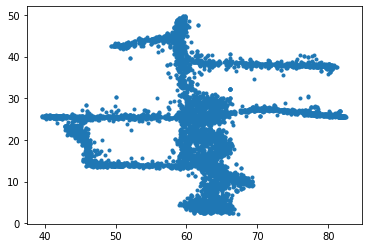

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

In [ ]:
all_targetsV.shape

(7369, 2)

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

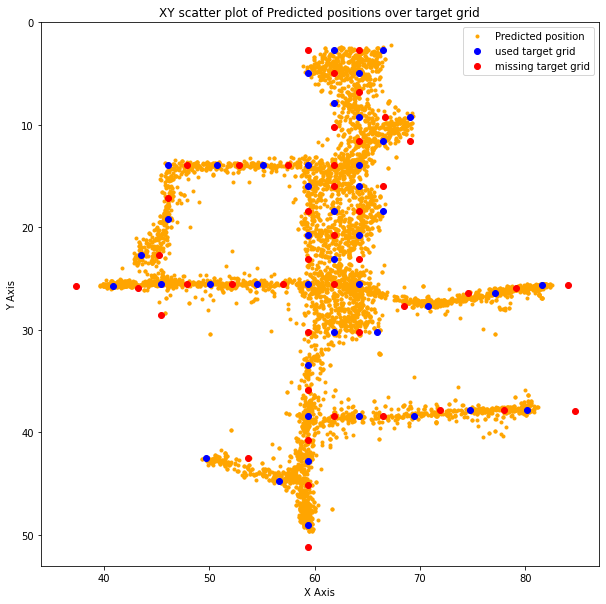

mean validation error, 5-fold 1.908833228779687


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')


plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position', color='orange')
# plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='half target grid')

plt.plot(uniquePoints.loc[uniquePoints.setNum==2,'x'].values,uniquePoints.loc[uniquePoints.setNum==2,'y'].values,'o', label='used target grid', color='blue')
plt.plot(uniquePoints.loc[uniquePoints.setNum==1,'x'].values,uniquePoints.loc[uniquePoints.setNum==1,'y'].values,'o', label='missing target grid', color='red')
# plt.plot(uniquePoints.iloc[:,0].values,uniquePoints.iloc[:,1].values,'o', label='missing target grid', color='r')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

plt.axis([34, 87, 53, 0])
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))

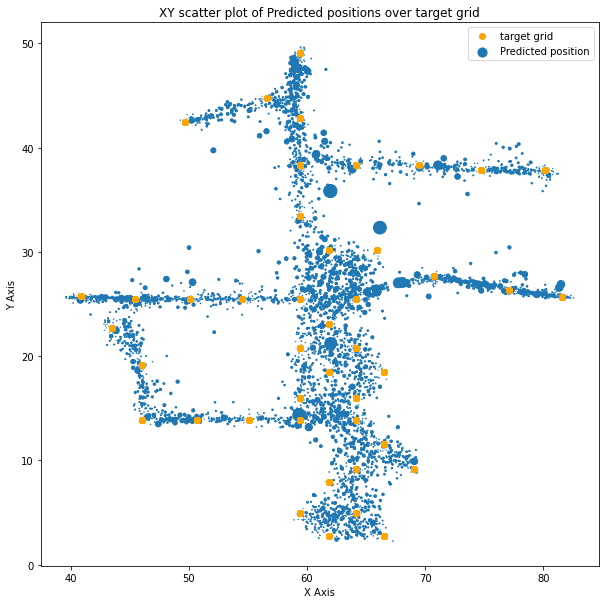

mean validation error, 5-fold 1.908833228779687


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

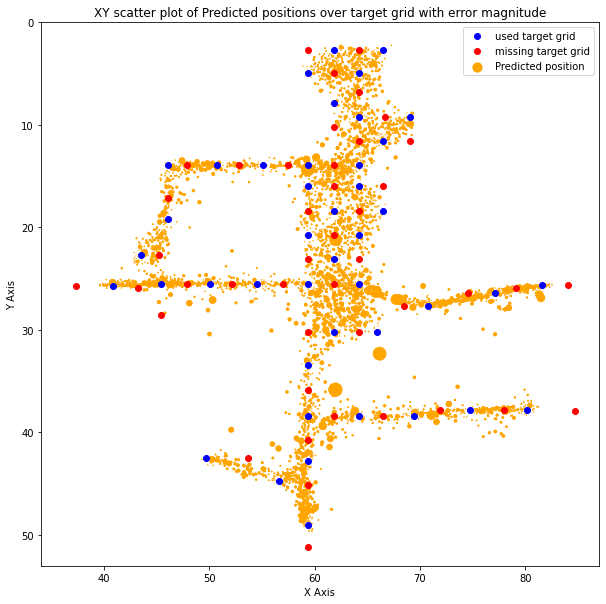

mean validation error, 5-fold 1.908833228779687


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid with error magnitude')
# plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position',color='orange')

plt.plot(uniquePoints.loc[uniquePoints.setNum==2,'x'].values,uniquePoints.loc[uniquePoints.setNum==2,'y'].values,'o', label='used target grid', color='blue')
plt.plot(uniquePoints.loc[uniquePoints.setNum==1,'x'].values,uniquePoints.loc[uniquePoints.setNum==1,'y'].values,'o', label='missing target grid', color='red')

plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

plt.axis([34, 87, 53, 0])
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
scoreperrow_othersplit=[]
for row in range(len(all_targetsV_othersplit)):
    scoreperrow_othersplit.append(euclidean_distance(all_targetsV_othersplit[row,0], all_targetsV_othersplit[row,1], all_predsV_othersplit[row,0], all_predsV_othersplit[row,1]))

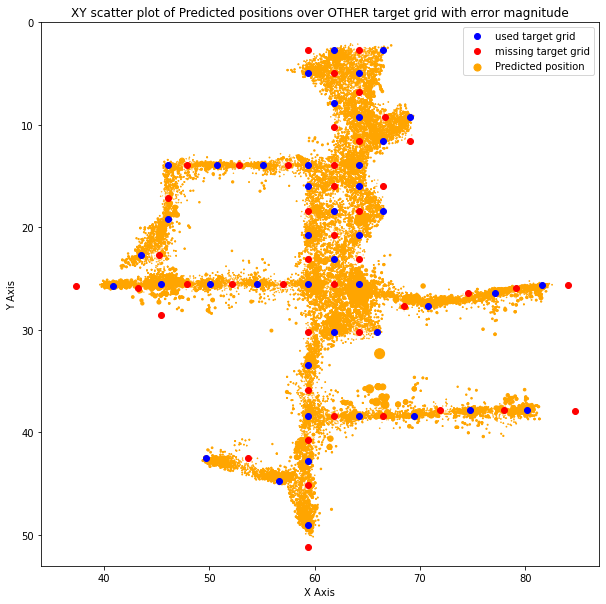

mean validation error, 5-fold 1.908833228779687


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over OTHER target grid with error magnitude')
# plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV_othersplit[:,0],all_predsV_othersplit[:,1],s=0.25*np.array(scoreperrow_othersplit)**2, label='Predicted position',color='orange')

plt.plot(uniquePoints.loc[uniquePoints.setNum==2,'x'].values,uniquePoints.loc[uniquePoints.setNum==2,'y'].values,'o', label='used target grid', color='blue')
plt.plot(uniquePoints.loc[uniquePoints.setNum==1,'x'].values,uniquePoints.loc[uniquePoints.setNum==1,'y'].values,'o', label='missing target grid', color='red')

plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

plt.axis([34, 87, 53, 0])
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
version

'forPdata423_halfgrid'

## Full train

In [ ]:
# hyper_params["num_iterations"]= 2500

In [ ]:


# name=version+'lgbm'

# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

# train_predsXY=[]
# all_train_targets=[]
# xy=['x', 'y']
# for i in range(2):
#     y_train = y_trainXY[:,i]

#     gbm = lgb.LGBMRegressor(**hyper_params)


#     model = gbm.fit(X_train, y_train,
#         eval_set=[(X_train, y_train)],
#         eval_metric='l1',
#         verbose=100
#         )
    
#     # joblib.dump(model, weights_path+'FullTrain_'+['x','y'][i])
#     joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model'+xy[i])

#     train_predsXY.append(gbm.predict(X_train, num_iteration=gbm.best_iteration_) )

# train_predsXY=np.stack(train_predsXY).T

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save LightGBM model fully trained')
# joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')